# Solar Power Data Modeling Part 2

#### Prepared By: Ben Chamblee -https://github.com/Bench-amblee

## Contents

* [Introduction](#Introduction)  
* [Imports](#Imports)  
* [Objectives](#Objectives)  
* [Better Solar Panels](#Better_Solar_Panels)  
* [How Much Extra Revenue Will Upgraded Arrays Generate?](#How_Much_Extra_Revenue_Will_Upgraded_Arrays_Generate?)  
* [Conclusion](#Conclusion)  
* [Future Plans](#Future_Plans)


## Introduction

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

gandikota = pd.read_csv('Data/Plant1_Data_Cleaned.csv')
gandikota_avg = pd.read_csv('Data/gandikota_averages.csv')
gand_coefs = pd.read_csv('Data/gand_coefs.csv')
noct = pd.read_csv('Data/noct_df.csv')
gandikota_historical = pd.read_csv('Data/gandikota_historical.csv')
solar_model = pickle.load(open('solar_power_prediction_model.sav', 'rb'))

## Objectives

- Test other NOCT values to see how much more power the plant could be generating
- Find out how much extra revenue the plant could generate by generating more power

## Better Solar Panels<a id='Better_Solar_Panels'></a>

We determined in the exploratory analysis notebook that each solar array has a Nominal Operating Cell Temperature of around 18 degrees. 

According to https://www.weamerisolar.eu/what-is-nominal-operating-cell-temperature/ that is well below average, it seems like our arrays are well due for an upgrade

So let's say we do upgrade them, what would it look like if the average NOCT was 48 degrees like the current industry standard?

Lets look at one year: 2020, to see how much of a difference this would make. First we'll need to sort our data:

In [2]:
datetimefix = [x[:-10] for x in gandikota_historical['dt_iso']]
gandikota_historical['dt_iso'] = datetimefix
gandikota_historical['dt_iso'] = pd.to_datetime(gandikota_historical['dt_iso'])

In [3]:
date_2020_list = []
current_2020 = 2020
for i in range(len(gandikota_historical)):
    date = gandikota_historical['dt_iso'][i]
    if date.year == current_2020:
        date_2020_list.append(date)

This is very similar to what we did in the last notebook, now that we have a list of each date we can create a list for each temperature and irradiation value to use in our equation. The key difference though is that we're changing the NOCT value to 48

In [4]:
power_2020 = []
mod_2020 = []
amb_2020 = []
DC_2020 = []
irr_2020 = []
mod_2020_df = pd.DataFrame()

for index,date in enumerate(date_2020_list):
    temp = gandikota_historical[gandikota_historical['dt_iso'] == date]['temp']
    temp = temp.values
    amb_2020.append(temp[0])
    irr = (gandikota_historical[gandikota_historical['dt_iso']==date]['irradiation']*100)
    irr = irr.values
    irr_2020.append(irr[0])
    NOCT = noct['gandikota'][0]
    mod = amb_2020[index] + ((NOCT - 20)/80)*irr
    mod_2020.append(mod[0])
for x in range(len(date_2020_list)):
    DC = mod_2020[x]*gand_coefs['a'][0]
    DC_2020.append(DC)

mod_2020_df['DC'] = DC_2020
mod_2020_df['amb'] = amb_2020
mod_2020_df['mod'] = mod_2020
mod_2020_df['irr'] = irr_2020
    
year_2020_pred = solar_model.predict(mod_2020_df)
year_2020_pred = year_2020_pred*22*4


In [5]:
power_2020_up = []
mod_2020_up = []
amb_2020_up = []
DC_2020_up = []
irr_2020_up = []
mod_2020_df_up = pd.DataFrame()

for index,date in enumerate(date_2020_list):
    temp = gandikota_historical[gandikota_historical['dt_iso'] == date]['temp']
    temp = temp.values
    amb_2020_up.append(temp[0])
    irr = (gandikota_historical[gandikota_historical['dt_iso']==date]['irradiation']*100)
    irr = irr.values
    irr_2020_up.append(irr[0])
    NOCT = 48
    mod = amb_2020[index] + ((NOCT - 20)/80)*irr
    mod_2020_up.append(mod[0])
for x in range(len(date_2020_list)):
    DC = mod_2020[x]*gand_coefs['a'][0]
    DC_2020_up.append(DC)

mod_2020_df_up['DC'] = DC_2020_up
mod_2020_df_up['amb'] = amb_2020_up
mod_2020_df_up['mod'] = mod_2020_up
mod_2020_df_up['irr'] = irr_2020_up 

year_2020_upgrade = solar_model.predict(mod_2020_df_up)

year_2020_upgrade = year_2020_upgrade*22*4

In [6]:
print('Amount of kWs produced in 2020 (current NOCT):',sum(year_2020_pred),'kWs')
print('Amount of kWs produced in 2020 (upgraded NOCT):',sum(year_2020_upgrade),'kWs')
print('Difference:',sum(year_2020_upgrade)-sum(year_2020_pred),'kWs')

Amount of kWs produced in 2020 (current NOCT): 1545069480.4345808 kWs
Amount of kWs produced in 2020 (upgraded NOCT): 1736457633.887714 kWs
Difference: 191388153.4531331 kWs


In [7]:
x_axis = []
for i in range(len(year_2020_pred)):
    x_axis.append(i)

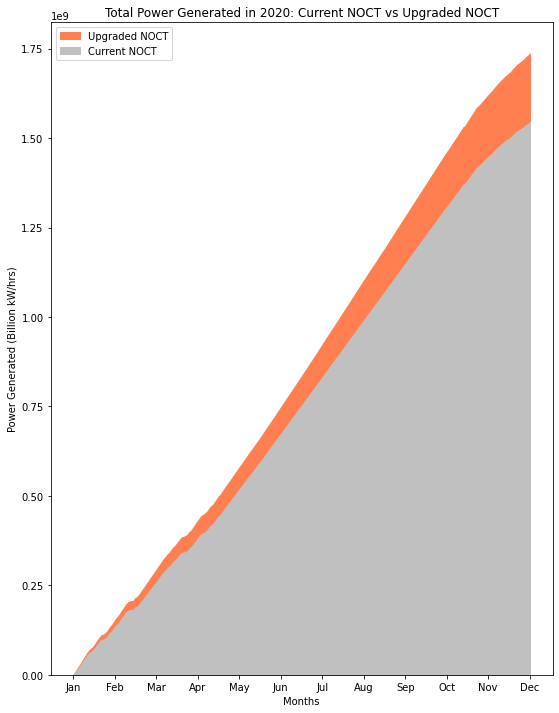

In [8]:
xtick_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig,ax=plt.subplots(figsize=(9,12))
ax.stackplot(x_axis,np.cumsum(year_2020_upgrade),
             labels=['Upgraded NOCT'],color='#FF7F50')
ax.stackplot(x_axis,np.cumsum(year_2020_pred),
             labels= ['Current NOCT'],color='#C0C0C0')
plt.title('Total Power Generated in 2020: Current NOCT vs Upgraded NOCT')
x_ticks = np.arange(0, 8807, 800)
plt.xticks(x_ticks)
ax.set_xticklabels(xtick_labels)
plt.xlabel('Months')
plt.legend()
ax.legend(loc='upper left')
plt.ylabel('Power Generated (Billion kW/hrs)');

## How Much Extra Revenue Will Upgraded Arrays Generate?<a id='How_Much_Extra_Revenue_Will_Upgraded_Arrays_Generate?'></a>

It was difficult to find data on power generation rates in this part of India, but according to https://en.wikipedia.org/wiki/Power_sector_of_Andhra_Pradesh#Solar The current rate is:

- 2.5 Rs ($0.033) per kW generated

In [9]:
revenue_2020 = 0.033*sum(year_2020_pred)
revenue_2020_up = 0.033*sum(year_2020_upgrade)

print('Current NOCT yearly revenue: $',revenue_2020)
print('Upgraded NOCT yearly revenue: $',revenue_2020_up)
print('Difference $',(revenue_2020_up-revenue_2020))

Current NOCT yearly revenue: $ 50987292.85434117
Upgraded NOCT yearly revenue: $ 57303101.918294564
Difference $ 6315809.063953392


This extra 6.3 Million, plus the tax breaks they'll get (see https://www.iea.org/reports/projected-costs-of-generating-electricity-2020) for more details, should very well put them in a position where they can recuperate their losses in no time and generate even more profit!

## Conclusion

Running a solar plant is not an small feat, and certainly one that can't be accomplished without significant financial contributions. I have no idea who made the Gandikota solar farm, when it was made, or how long it's been running, however it seems as though it's time for an upgrade.

The plant would have gained an additional $6.3 million, with smart investment strategies that could have gone on to pay more salaries, improve the plant's other important facilities, or expand the power plant to produce even more power. Upgrading an entire power plant is no easy task, but I think with what we now know about solar efficiency and the potential it has - upgrading seems like the best course of action

With this analysis I not only learned a ton about how solar farms and solar panels operate, but also the importance of using current, efficient technology. In addition to this, the impressive performance of machine learning models cannot be understated. The fact that this gradient boosting model was able to predicted nearly as accurately as a scientifically-backed mathematical equation is amazing! 

If you've read this far, thank you so much for going through this data-journey with me! A full report and slides will be available on my github.


## Future Plans<a id='Future_Plans'></a>

openweathermap.org has an api that tracks the meteorological data of a location by coordinates! With this in mind I had to see what the weather in Gandikota was today (April 15th, 2021)

In [10]:
import requests
url = 'https://api.openweathermap.org/data/2.5/weather?lat=14.8149&lon=78.2863&appid=aea0e44e37bc6bb1de652ad34919442d&units=metric'
current_weather = requests.get(url)
current_weather = current_weather.json()
current_weather

{'coord': {'lon': 78.2863, 'lat': 14.8149},
 'weather': [{'id': 804,
   'main': 'Clouds',
   'description': 'overcast clouds',
   'icon': '04n'}],
 'base': 'stations',
 'main': {'temp': 28.98,
  'feels_like': 30.28,
  'temp_min': 28.98,
  'temp_max': 28.98,
  'pressure': 1009,
  'humidity': 55,
  'sea_level': 1009,
  'grnd_level': 977},
 'visibility': 10000,
 'wind': {'speed': 8.51, 'deg': 95, 'gust': 10.63},
 'clouds': {'all': 92},
 'dt': 1618501986,
 'sys': {'country': 'IN', 'sunrise': 1618446766, 'sunset': 1618491637},
 'timezone': 19800,
 'id': 1269323,
 'name': 'Jammalamadugu',
 'cod': 200}

In [11]:
current_weather['main']['temp']

28.98

And if we apply the model we can determine how much power the gandikota plant is generating and how much it would be generating with upgraded arrays

In [12]:
def current_power(temp,irr):
    model_df = pd.DataFrame()
    a_temp = []
    m_temp = []
    irradiation = []
    DC_power = []
    NOCT = noct['gandikota'][0]
    a_temp.append(temp)
    irradiation.append(irr)
    
    mod = a_temp + ((NOCT-20)/80)*irr
    m_temp.append(mod)
    
    DC = mod*gand_coefs['a'][0]
    DC_power.append(DC)
    
    model_df['a'] = a_temp
    model_df['m'] = m_temp
    model_df['i'] = irradiation
    model_df['d'] = DC_power
    
    current_pred = solar_model.predict(model_df)
    current_pred = current_pred*22*4
    current_pred = np.mean(current_pred)
    current_pred = int(current_pred)
    result = str(current_pred) + ' kW/hr'
    return result


In [13]:
power_generation_rn = current_power(current_weather['main']['temp'],(1-current_weather['clouds']['all']))

print('At the current temperature and irradiation levels, the Gandikota Power Plant will produce',power_generation_rn,'in the next hour')

At the current temperature and irradiation levels, the Gandikota Power Plant will produce 28483 kW/hr in the next hour


In [22]:
def current_power_upgraded(temp,irr):
    model_df = pd.DataFrame()
    a_temp = []
    m_temp = []
    irradiation = []
    DC_power = []
    NOCT = 48
    
    a_temp.append(temp)
    irradiation.append(irr)
    
    mod = temp + ((NOCT-20)/80)*irr
    m_temp.append(mod)
    
    DC = mod*gand_coefs['a'][0]
    DC_power.append(DC)
    
    model_df['a'] = a_temp
    model_df['m'] = m_temp
    model_df['i'] = irradiation
    model_df['d'] = DC_power
    
    current_pred = solar_model.predict(model_df)
    current_pred = current_pred*22*4
    current_pred = np.mean(current_pred)
    current_pred = int(current_pred)
    result = str(current_pred) + ' kW/hr'
    return result

In [23]:
power_generation_rn_upgraded = current_power_upgraded(current_weather['main']['temp'],(1-current_weather['clouds']['all']))

print('At the current temperature and irradiation levels, the Gandikota Power Plant (with upgraded solar arrays) will produce',power_generation_rn_upgraded,'in the next hour')

At the current temperature and irradiation levels, the Gandikota Power Plant (with upgraded solar arrays) will produce 28911 kW/hr in the next hour


I'm planning on incorporating this into a web app that will provide live updates. That will also be on my github once I make it!